In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from scipy.optimize import curve_fit
import scipy.stats as ss
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
def Data_preprocess(df):
    """
    Function to clean a data frame with required columns 
    """
    # Drop unnecessary columns
    df = df.drop(['Country Name','Country Code','Series Code'], axis=1)
    
    # Set index to 'Series Name' and transpose the DataFrame
    df.set_index('Series Name', inplace=True)
    df = df.T
    
    # Extract only the first part of the index (year)
    df.index = df.index.str.split().str.get(0)
    
    # Convert index to integer
    df.index = df.index.astype(int)
    
    # Remove data for years 2022 and 2023
    df = df.drop([2022, 2023], axis=0, errors='ignore')
    
    # Rename columns for clarity
    df.columns.name = ''
    df = df.rename(columns={
        "GDP growth (annual %)": "GDP growth %",
        "Population growth (annual %)": "Population growth %",
        "Population density (people per sq. km of land area)": "Population density per sq.km",
        "Agricultural irrigated land (% of total agricultural land)": "Agricultural irrigated land %",
        "Agricultural land (% of land area)": "Agricultural land %",
        "Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent)": "Agricultural N2O Emissions"
    })
    
    # Convert any remaining missing values ('..') to NaN
    df.replace('..', pd.NA, inplace=True)
    
    # Convert all columns to numeric, coercing errors
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Fill missing values with median
    df.fillna(df.median(), inplace=True)
    
    return df

In [3]:
x = ['Brazil' , 'Poland' ,'UK','US','China','Ethiopia' ,'India']    
def Histogram_Plot(*df):
    """
    Defining a function to create a histogram 
    to understand the frequency of GDP growth %
    for different countries across the years
    """
    plt.figure(figsize=(7, 5))
    
    # plotting an overlapped histogram to observe the frequency of the population.
    for i, df in enumerate(df):
        sns.histplot(df['Population growth %'], kde=True, stat="density"
                     ,bins=10,linewidth=0, label=x[i],alpha=0.5)
    
    #set the titles, legend, labels and grid 
    plt.title('Distribution of population Growth %')
    plt.xlabel('Annual population Growth %')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.legend()
    # Save the plot as histogram.png
    plt.savefig('histogram.png')
    # Show the plot
    plt.show()
    return

In [4]:
def Line_Plot(*df):
    """
    Defining a function to create a Line plot 
    to identify the relation between agricultural land across countries
    """
    plt.figure(figsize=(7, 5))
    
    cmap = ['red','blue','orange','green','yellow' , 'black' , 'purple']
    
    #plotting the data
    for i, df in enumerate(df):
        sns.lineplot( data = df['Agricultural land %'], 
                     color = cmap[i],marker ='o',label = x[i])
        
    
    #set the titles, labels, limits and grid values
    plt.title('Relation between Agricultural land across countries')
    plt.xlabel('Years')
    plt.ylabel('Agricultural Land %')
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # Save the plot as Linegraph.png
    plt.savefig('Linegraph.png')
    # Show the plot
    plt.show()
    return

In [5]:
def plot_corr_heatmap(data):
    """
    Plot a heatmap for the correlation matrix of the given DataFrame.

    """
    # Calculate the correlation matrix
    corr_matrix = data.corr()

    # Generate a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix Heatmap')
    plt.savefig('heatmap.png')
    plt.show()

In [6]:
def plot_elbow_and_silhouette(K_range, inertia, silhouette_scores):
    """
    Plot the Elbow Curve and Silhouette Scores.
    
   
    """
    plt.figure(figsize=(14, 6))
    
    # Plot Elbow Curve
    plt.subplot(121)
    plt.plot(K_range, inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    
    # Plot Silhouette Scores
    plt.subplot(122)
    plt.plot(K_range, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score For Optimal k')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    return

In [7]:
def plot_cluster_with_centers(principal_df, kmeans, pca):
    """
    Plot the clusters along with their centers transformed by PCA.
   
   
    """
    plt.figure(figsize=(10, 8))
    colors = ['r', 'g', 'b', 'c']  # Define colors for clusters
    for color, label in zip(colors, range(4)):
        indicesToKeep = principal_df['Cluster'] == label
        plt.scatter(principal_df.loc[indicesToKeep, 'Principal Component 1'],
                    principal_df.loc[indicesToKeep, 'Principal Component 2'], c=color, s=50)
    plt.title('2D PCA Clustering Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    # Plot cluster centers transformed by PCA
    centers = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers[:, 0], centers[:, 1], s=300, c='black', marker='X', label='Centers')

    plt.legend()
    plt.show()
    return

In [8]:
def plot_logistic_fit(df_fit, metric_column, p, sample_params=None):
    """
    Plot logistic fit for emissions data along with uncertainties.

    """
    fig, ax = plt.subplots(dpi=144)
    time_predictions = np.arange(1990, 2050, 1)
    emissions_predictions = Logistic_Fit(time_predictions - 2003, *p)
    
    if sample_params is not None:
        emissions_uncertainties = [np.std(Logistic_Fit(future_time - 2003, *sample_params.T)) for future_time in time_predictions]
        ax.fill_between(time_predictions, emissions_predictions - emissions_uncertainties, emissions_predictions + emissions_uncertainties, color='gray', alpha=0.5)
    
    ax.plot(df_fit.index, df_fit[metric_column], 'b-', label='Data')
    ax.plot(time_predictions, emissions_predictions, 'k-', label='Logistic Fit')
    ax.set_xlabel('Years')
    ax.set_ylabel(metric_column)
    ax.grid()
    ax.legend()
    plt.show()

In [9]:
def plot_logistic_fit(df_fit, metric_column, p, sample_params=None):
    """
    Plot logistic fit for emissions data along with uncertainties.

    """
    fig, ax = plt.subplots(dpi=144)
    time_predictions = np.arange(1990, 2050, 1)
    emissions_predictions = Logistic_Fit(time_predictions - 2003, *p)
    
    if sample_params is not None:
        emissions_uncertainties = [np.std(Logistic_Fit(future_time - 2003, *sample_params.T)) for future_time in time_predictions]
        ax.fill_between(time_predictions, emissions_predictions - emissions_uncertainties, emissions_predictions + emissions_uncertainties, color='gray', alpha=0.5)
    
    ax.plot(df_fit.index, df_fit[metric_column], 'b-', label='Data')
    ax.plot(time_predictions, emissions_predictions, 'k-', label='Logistic Fit')
    ax.set_xlabel('Years')
    ax.set_ylabel(metric_column)
    ax.grid()
    ax.legend()
    plt.show()

In [11]:
# Loading the data set 
df = pd.read_csv("C:/Users/Inspiron/Downloads/Data.csv")  # Modify this path to the correct one

# Filter DataFrames for each country
df_Brazil = df[df['Country Name'] == 'Brazil']
df_Poland = df[df['Country Name'] == 'Poland']
df_United_Kingdom = df[df['Country Name'] == 'United Kingdom']
df_United_States = df[df['Country Name'] == 'United States']
df_China = df[df['Country Name'] == 'China']
df_Ethiopia = df[df['Country Name'] == 'Ethiopia']
df_India = df[df['Country Name'] == 'India']

# Preprocessing each country's DataFrame
df_Brazil = Data_preprocess(df_Brazil)
df_Poland = Data_preprocess(df_Poland)
df_United_Kingdom =Data_preprocess(df_United_Kingdom)
df_United_States = Data_preprocess(df_United_States)
df_China = Data_preprocess(df_China)
df_Ethiopia = Data_preprocess(df_Ethiopia)
df_India = Data_preprocess(df_India)

df_India.head()

,GDP growth %,Population growth %,Population density per sq.km,CO2 emissions (kt),Agricultural irrigated land %,Agricultural land %,Agricultural land (sq. km),Agricultural N2O Emissions
1990,5.533455,2.141141,292.767084,563575.4,35.398787,61.016282,1814130.0,132080.2454
1991,1.056831,2.101891,298.985856,607224.0,35.398787,61.074469,1815860.0,135840.2604
1992,5.482396,2.074344,305.252624,626293.3,35.398787,60.979958,1813050.0,139729.8160
1993,4.750776,2.047837,311.568146,651351.1,35.398787,61.005856,1813820.0,142914.4824
1994,6.658924,2.020856,317.928541,685903.0,35.398787,60.975249,1812910.0,148234.5870


In [12]:
df_Brazil.describe()

,GDP growth %,Population growth %,Population density per sq.km,CO2 emissions (kt),Agricultural irrigated land %,Agricultural land %,Agricultural land (sq. km),Agricultural N2O Emissions
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,3.200000e+01,32.000000
mean,2.113563,1.157075,22.235860,344694.340625,2.429764,27.744611,2.318933e+06,134494.890975
std,2.978235,0.349121,2.319504,90598.345562,0.123030,0.441241,3.687954e+04,24500.994698
min,-4.350000,0.528590,18.031099,197897.400000,1.945394,27.255466,2.278050e+06,97837.572000
25%,0.494951,0.865718,20.389289,288274.150000,2.429764,27.351621,2.286087e+06,110492.223950
50%,2.065020,1.097278,22.470192,331689.100000,2.429764,27.623012,2.308770e+06,138766.560800
75%,4.264833,1.476293,24.186749,422181.250000,2.429764,28.087954,2.347630e+06,155259.802900
max,7.528226,1.809856,25.642813,511618.000000,2.914134,28.639094,2.393696e+06,178417.725600


In [13]:
df_Poland.describe()

,GDP growth %,Population growth %,Population density per sq.km,CO2 emissions (kt),Agricultural irrigated land %,Agricultural land %,Agricultural land (sq. km),Agricultural N2O Emissions
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,3.748358,-0.017700,124.741980,312978.340625,0.476496,53.504340,163861.081250,19251.782469
std,2.796047,0.248277,0.788945,21573.659262,0.086409,5.895780,18077.809851,538.721995
min,-7.015579,-1.044335,123.316315,279223.800000,0.318361,46.934910,143710.000000,18299.673400
25%,2.909025,-0.061113,124.192969,297613.175000,0.465447,47.432423,145202.500000,18838.502100
50%,4.383299,-0.016365,124.539456,308978.100000,0.465447,52.008489,159315.000000,19242.515600
75%,5.178214,0.066032,124.995555,323748.625000,0.465447,60.225603,184465.000000,19552.353650
max,7.102866,0.392398,126.231614,355320.200000,0.923195,61.356884,187930.000000,20604.971600


In [14]:
df_United_Kingdom.describe()

,GDP growth %,Population growth %,Population density per sq.km,CO2 emissions (kt),Agricultural irrigated land %,Agricultural land %,Agricultural land (sq. km),Agricultural N2O Emissions
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,1.815486,0.502152,253.925272,489288.056250,0.624861,71.851482,173830.290969,25607.866375
std,3.040008,0.234394,13.778664,72916.339472,0.191431,1.389101,3360.651264,2130.279385
min,-10.359901,-0.081937,236.628719,308650.300000,0.283649,70.073988,169530.000000,23119.942600
25%,1.485651,0.297049,241.576465,451745.675000,0.598521,71.001943,171775.000000,23953.731700
50%,2.406386,0.514886,250.584934,526000.600000,0.598521,71.663253,173374.909000,24720.768800
75%,2.820676,0.735403,265.559374,541547.500000,0.598521,72.436126,175244.720750,27797.745450
max,8.674904,0.792368,277.275385,570681.600000,1.338759,75.240772,182030.000000,29810.608800


In [15]:
df_United_States.describe()

,GDP growth %,Population growth %,Population density per sq.km,CO2 emissions (kt),Agricultural irrigated land %,Agricultural land %,Agricultural land (sq. km),Agricultural N2O Emissions
count,32.000000,32.000000,32.000000,3.200000e+01,32.000000,32.000000,3.200000e+01,32.000000
mean,2.410561,0.926796,32.245781,5.243586e+06,5.548973,45.031778,4.122536e+06,172521.031975
std,1.862460,0.274739,2.777828,3.775974e+05,0.055444,0.745510,7.041031e+04,5813.719825
min,-2.767803,0.156747,27.254514,4.320532e+06,5.409802,44.064999,4.030811e+06,159208.645600
25%,1.805392,0.733540,30.031221,4.970489e+06,5.548160,44.363367,4.058104e+06,169386.880300
50%,2.695293,0.936831,32.411138,5.156425e+06,5.548160,45.069068,4.129192e+06,172721.276800
75%,3.584972,1.152108,34.615393,5.597023e+06,5.548160,45.292119,4.148998e+06,176778.084900
max,5.945485,1.386886,36.297836,5.775807e+06,5.785517,46.615336,4.269480e+06,181396.861400


In [16]:
df_China.describe()

,GDP growth %,Population growth %,Population density per sq.km,CO2 emissions (kt),Agricultural irrigated land %,Agricultural land %,Agricultural land (sq. km),Agricultural N2O Emissions
count,32.000000,32.000000,32.000000,3.200000e+01,0.0,32.000000,3.200000e+01,32.000000
mean,9.091342,0.728561,138.225518,6.174387e+06,NaN,55.669513,5.226377e+06,320200.760669
std,2.740317,0.320309,8.790126,3.140509e+06,NaN,0.503158,4.723184e+04,31618.213447
min,2.238638,0.089252,120.915506,2.173364e+06,NaN,53.864565,5.056940e+06,253820.755000
25%,7.602680,0.540411,131.970563,3.148774e+06,NaN,55.602839,5.220111e+06,304245.625550
50%,9.185205,0.626594,139.256554,5.824625e+06,NaN,55.698794,5.229122e+06,326524.828200
75%,10.244184,0.975525,145.437187,9.620225e+06,NaN,55.963459,5.253968e+06,347067.733850
max,14.230861,1.467303,150.439754,1.094469e+07,NaN,56.263925,5.282176e+06,358003.641000


In [17]:
df_Ethiopia.describe()

,GDP growth %,Population growth %,Population density per sq.km,CO2 emissions (kt),Agricultural irrigated land %,Agricultural land %,Agricultural land (sq. km),Agricultural N2O Emissions
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,6.785311,2.990485,74.087882,7037.725000,0.533226,33.381301,361884.812500,30542.285953
std,5.709774,0.380972,17.220476,5111.414637,0.377819,5.921771,71676.156751,9276.331435
min,-8.672480,2.604319,43.485988,1517.200000,0.323963,29.329328,304490.000000,19460.502600
25%,4.669101,2.742548,62.660740,3147.050000,0.447230,30.500000,305527.500000,22074.078902
50%,8.505949,2.850920,71.862112,5334.200000,0.447230,31.343122,350310.000000,27326.540400
75%,10.800073,3.077403,86.614507,8966.950000,0.447230,33.125507,373840.250000,37896.890950
max,13.572603,4.211319,106.579912,18098.000000,2.080705,51.146231,563120.000000,50450.625200


C:\Users\Inspiron\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Inspiron\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Inspiron\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


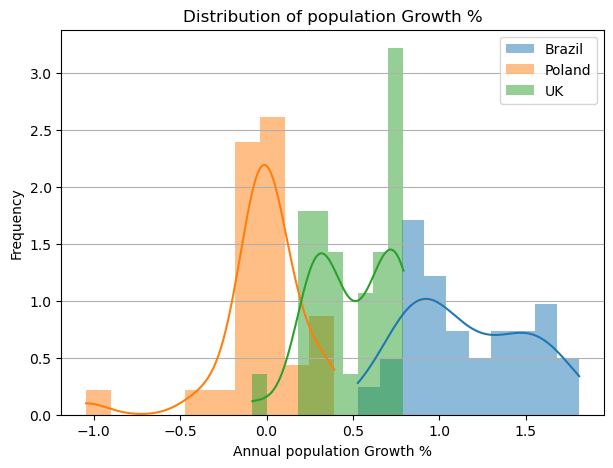

C:\Users\Inspiron\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Inspiron\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Inspiron\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Inspiron\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

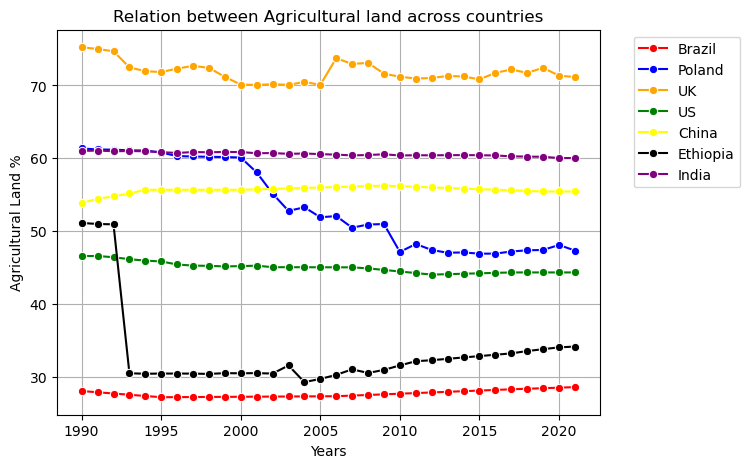

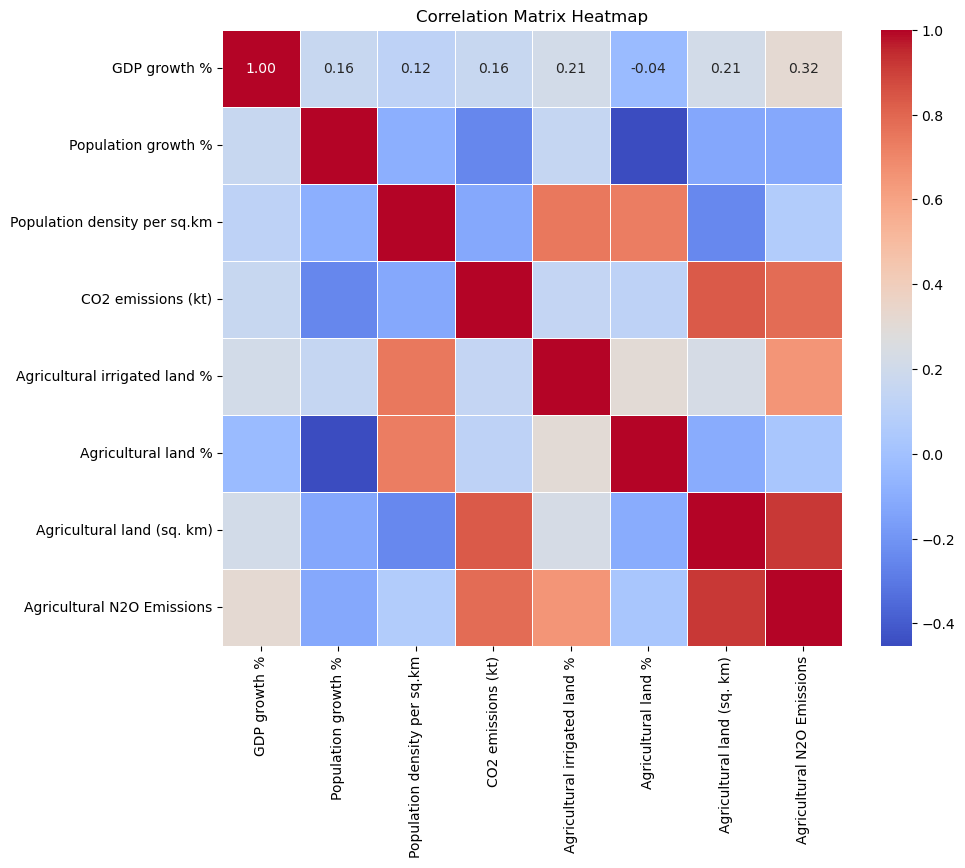

In [18]:
#Plot histogram decribing the population growth of Brazil , Poland and UK
Histogram_Plot(df_Brazil,df_Poland,df_United_Kingdom)

#plotting Line graph
Line_Plot(df_Brazil,df_Poland,df_United_Kingdom,df_United_States,df_China,df_Ethiopia,df_India)

#dataframe which includes all the countries data
data= pd.concat([df_Brazil,df_Poland,df_United_Kingdom,df_United_States,df_China,df_Ethiopia,df_India])

#plotting heatmap 
plot_corr_heatmap(data)

In [19]:
#Using describe function for mean, stanadrd deviation, min and max value.
print('Stats of the data', end='\n')
data.describe()


#basic statistics of the data

print('Skewness of the data', end='\n')
print(data.skew() , end='\n\n')

print('Kurtosis of the data', end='\n')
print(data.kurtosis() , end='\n\n')

print('Correlation of the data', end='\n')
print(data.corr() , end='\n\n')

Stats of the data
Skewness of the data

GDP growth %                    -0.306326
Population growth %              0.922194
Population density per sq.km     1.003840
CO2 emissions (kt)               1.596631
Agricultural irrigated land %    1.756066
Agricultural land %             -0.144021
Agricultural land (sq. km)       0.545127
Agricultural N2O Emissions       0.645725
dtype: float64

Kurtosis of the data

GDP growth %                     0.909773
Population growth %              0.440141
Population density per sq.km     0.037311
CO2 emissions (kt)               1.765646
Agricultural irrigated land %    1.275851
Agricultural land %             -1.125859
Agricultural land (sq. km)      -1.170733
Agricultural N2O Emissions      -0.615157
dtype: float64

Correlation of the data
                               GDP growth %  Population growth %  \
                                                                   
GDP growth %                       1.000000             0.163818   
Popula

C:\Users\Inspiron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Inspiron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Inspiron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Inspiron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting t

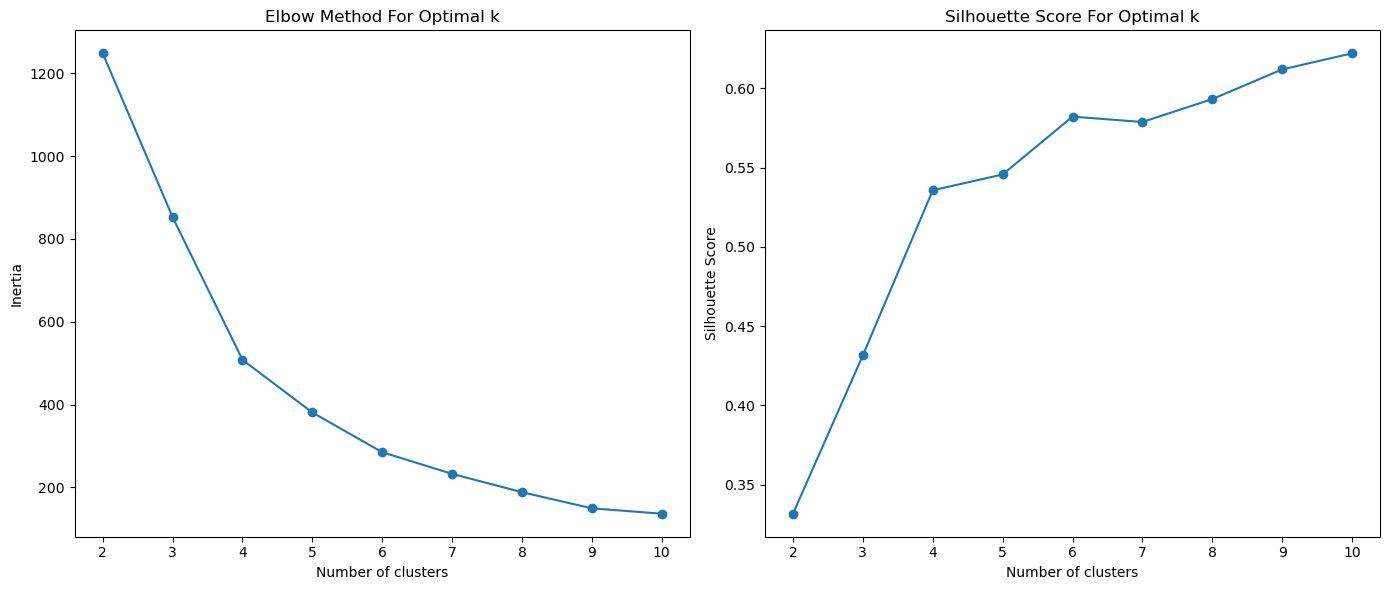

In [20]:
# Fill missing 'Agricultural irrigated land %' with the mean from all data
mean_irrigated_land = data['Agricultural irrigated land %'].mean()
data['Agricultural irrigated land %'].fillna(mean_irrigated_land, inplace=True)

scaler = StandardScaler()
data_normalized = scaler.fit_transform(data.select_dtypes(include=[np.number]))

# Normalize the data again
data_normalized = scaler.fit_transform(data)

# Determine the optimal number of clusters again using the Elbow method and Silhouette score
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_normalized, kmeans.labels_))

plot_elbow_and_silhouette(K_range, inertia, silhouette_scores)

C:\Users\Inspiron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Inspiron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


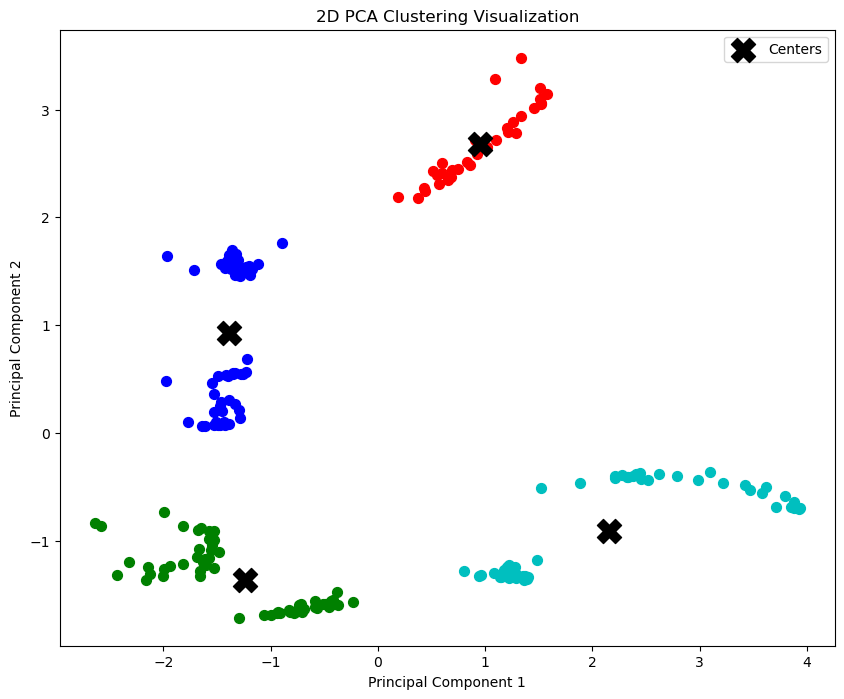

In [21]:
# Perform K-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_normalized)

# Add cluster labels to the data
data['Cluster'] = clusters

# Visualize the clusters using PCA to reduce dimensionality to 2D for plotting
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_normalized)
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Merge with cluster labels
principal_df['Cluster'] = clusters

plot_cluster_with_centers(principal_df, kmeans, pca)

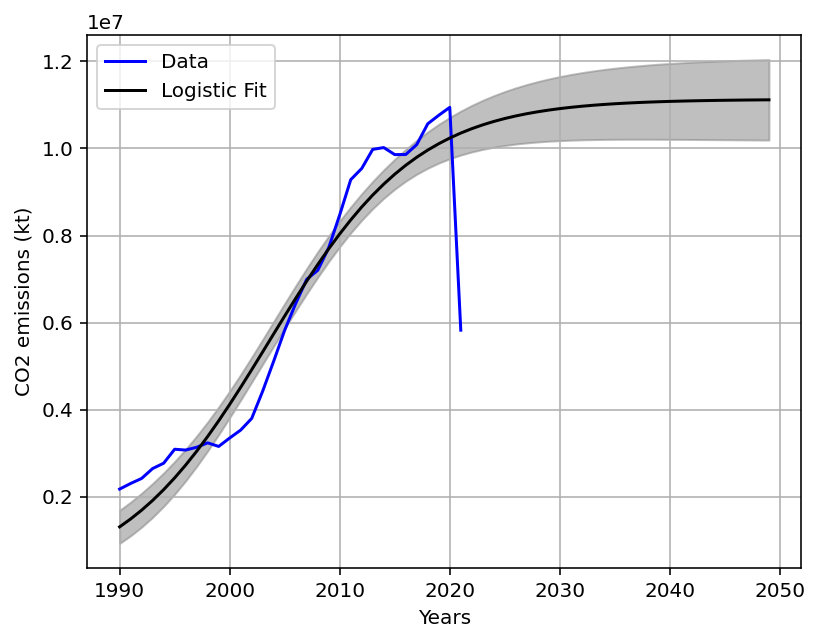

Emissions in 2050: 1.11197e+07 +/- 928554


In [22]:
# Logistic function definition
def Logistic_Fit(t, L, k, x0):
    return L / (1 + np.exp(-k * (t - x0)))


metric_column = 'CO2 emissions (kt)' 

# Creating a new dataframe with only the specific metric for China
df_China_fit = df_China[[metric_column]]
df_China_fit.index = df_China_fit.index.astype(int)

# Normalize the time frame
numeric_index = (df_China_fit.index - 2003).values

# Initial guesses for L, k, x0 based on data exploration
p, cov = curve_fit(Logistic_Fit, numeric_index, df_China_fit[metric_column],
                   p0=[max(df_China_fit[metric_column]), 0.03, 10])

# Predictions for 2050
CO2_2050 = Logistic_Fit(2050 - 2003, *p)

# Uncertainty calculation
sample_params = ss.multivariate_normal.rvs(mean=p, cov=cov, size=1000)
CO2_unc_2050 = np.std(Logistic_Fit(2050 - 2003, *sample_params.T))


plot_logistic_fit(df_China_fit, "CO2 emissions (kt)", p, sample_params)
print(f"Emissions in 2050: {CO2_2050:g} +/- {CO2_unc_2050:g}")

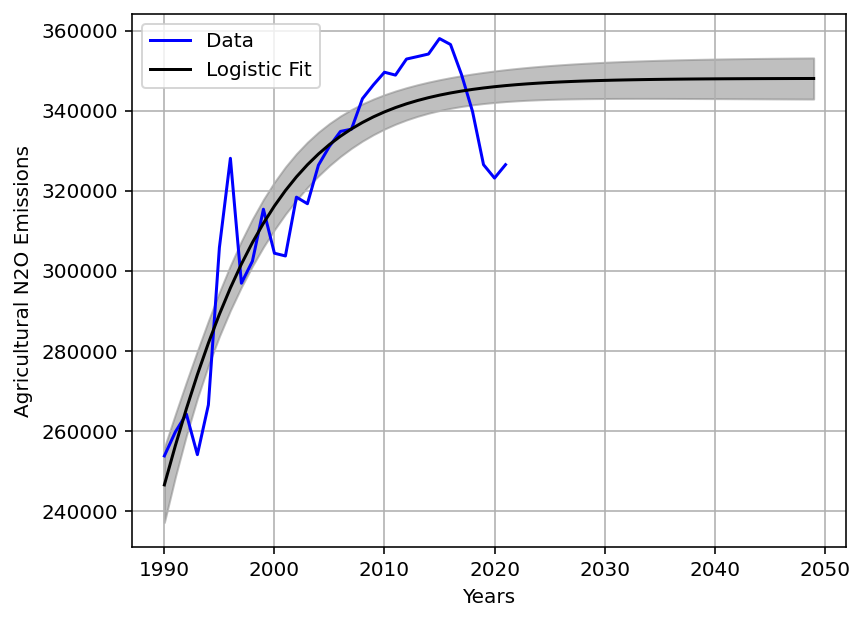

Agricultural N2O Emissions in 2050: 348044 +/- 5148.74


In [23]:
# Define the logistic function to model the emissions
def Logistic_Fit(t, L, k, x0):
    return L / (1 + np.exp(-k * (t - x0)))


# Create a DataFrame for 'Agricultural N2O Emissions'
df_China_fit = df_China[['Agricultural N2O Emissions']]
df_China_fit.index = df_China_fit.index.astype(int)

# Normalize the time frame (years are shifted so 2003 is 0)
numeric_index = (df_China_fit.index - 2003).values

# Initial guesses for the parameters: L (maximum emission), k (growth rate), x0 (midpoint)
# You may need to adjust these based on your data visualization
p, cov = curve_fit(Logistic_Fit, numeric_index, df_China_fit['Agricultural N2O Emissions'],
                   p0=[max(df_China_fit['Agricultural N2O Emissions']), 0.03, 10])

# Predictions for 2050
N2O_2050 = Logistic_Fit(2050 - 2003, *p)

# Uncertainty calculation
sample_params = ss.multivariate_normal.rvs(mean=p, cov=cov, size=1000)
N2O_unc_2050 = np.std(Logistic_Fit(2050 - 2003, *sample_params.T))

plot_logistic_fit(df_China_fit, "Agricultural N2O Emissions", p, sample_params)
print(f"Agricultural N2O Emissions in 2050: {N2O_2050:g} +/- {N2O_unc_2050:g}")